# 12 Word World

In [1]:
# Python dependencies
import warnings
import random

# 3rd Party dependencies
import torch
import numpy as np
import umap
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.ticker import MaxNLocator

In [2]:
torch.manual_seed(123)
warnings.filterwarnings('ignore')

## Intentionally Limited Vocabulary

We'll train a model with a text that's limited to this vocabulary.

In [3]:
adjectives = ["serene", "vibrant", "silent", "endless"]
nouns = ["river", "dream", "mountain", "idea"]
verbs = ["flows", "grows", "whispers", "shines"]

We generate random sentences with those words by randomly concatenating a noun, an adjective and a verb.

In [4]:
sentence_count = 100

twelve_word_world = [
    random.choice(adjectives) + " " + random.choice(nouns) + " " + random.choice(verbs)
    for _ in range(sentence_count)
]

In [5]:
from scratch.tokenizers.preprocessor import Preprocessor
from scratch.tokenizers.simple_tokenizer import SimpleTokenizer

def strings_to_text(strings: list[str]):
    return ".<|endoftext|> ".join(strings) + ".<|endoftext|>"

text_data = strings_to_text(twelve_word_world)

text_data

'vibrant mountain flows.<|endoftext|> serene idea shines.<|endoftext|> endless river grows.<|endoftext|> serene mountain shines.<|endoftext|> endless river shines.<|endoftext|> endless dream grows.<|endoftext|> vibrant dream flows.<|endoftext|> serene mountain whispers.<|endoftext|> serene mountain whispers.<|endoftext|> endless idea flows.<|endoftext|> endless dream whispers.<|endoftext|> serene mountain shines.<|endoftext|> silent mountain whispers.<|endoftext|> endless dream whispers.<|endoftext|> serene idea flows.<|endoftext|> serene mountain shines.<|endoftext|> endless river shines.<|endoftext|> vibrant mountain whispers.<|endoftext|> endless mountain grows.<|endoftext|> endless idea grows.<|endoftext|> silent river flows.<|endoftext|> silent river shines.<|endoftext|> serene mountain shines.<|endoftext|> silent river shines.<|endoftext|> vibrant idea shines.<|endoftext|> vibrant river whispers.<|endoftext|> serene mountain grows.<|endoftext|> silent idea whispers.<|endoftext|> 

In [6]:
all_tokens = adjectives + nouns + verbs + [".", "<|endoftext|>", "<|unk|>"]
random.shuffle(all_tokens)

randomized_tokens = " ".join(all_tokens)

In [7]:
preprocessor = Preprocessor()
source = preprocessor.preprocess(randomized_tokens)
tokenizer = SimpleTokenizer(source)

print("Vocabulary size", len(tokenizer.str_to_int))
print("Sentences", len(twelve_word_world))
print("Total characters", len(text_data))
print("Total tokens", len(tokenizer.encode(text_data)))

Vocabulary size 15
Sentences 100
Total characters 3504
Total tokens 500


In [8]:
tokenizer.int_to_str

{0: '.',
 1: '<|endoftext|>',
 2: '<|unk|>',
 3: 'dream',
 4: 'endless',
 5: 'flows',
 6: 'grows',
 7: 'idea',
 8: 'mountain',
 9: 'river',
 10: 'serene',
 11: 'shines',
 12: 'silent',
 13: 'vibrant',
 14: 'whispers'}

## Micro GPT Model

We instantiate a very tiny model in order to make it quite easy to debug.

In [9]:
from scratch.gpt_config import GptConfig
from scratch.gpt_model import GptModel

config = GptConfig(
    vocab_size = len(tokenizer.str_to_int),
    context_length = 5,
    embedding_dimension = 3,
    head_count = 1,
    layer_count = 1,
    drop_rate = 0,
    qkv_bias = False
)

model = GptModel(config)

Now that our model has just been created with random weights, we'll store its embedding weights so that we can later compare the initial values with the trained ones.

In [10]:
initial_embeddings = model.token_embeddings.weight.clone()

### Count the Model Parameters

In [11]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

249

### Preparing the Training and Validation Datasets

In [12]:
train_ratio = 0.9
split_idx = int(train_ratio * len(twelve_word_world))

train_data = strings_to_text(twelve_word_world[:split_idx])
validation_data = strings_to_text(twelve_word_world[split_idx:])

print(validation_data)

vibrant river shines.<|endoftext|> vibrant river flows.<|endoftext|> endless idea shines.<|endoftext|> silent mountain shines.<|endoftext|> endless idea flows.<|endoftext|> serene mountain grows.<|endoftext|> silent dream shines.<|endoftext|> vibrant dream grows.<|endoftext|> silent river flows.<|endoftext|> endless idea whispers.<|endoftext|>


In [13]:
from scratch.dataloader import create_dataloader

train_loader = create_dataloader(
    train_data,
    batch_size=2,
    max_length=config.context_length,
    stride=config.context_length,
    drop_last=True,
    shuffle=True,
    num_workers=0,
    tokenizer=tokenizer,
)

validation_loader = create_dataloader(
    validation_data,
    batch_size=2,
    max_length=config.context_length,
    stride=config.context_length,
    drop_last=False,
    shuffle=False,
    num_workers=0,
    tokenizer=tokenizer,
)

### Checking the Losses before Training

In [14]:
from scratch.training.loader_loss import LoaderLoss

loader_loss = LoaderLoss(model)

with torch.no_grad():
    train_loss = loader_loss.calc(train_loader)
    validation_loss = loader_loss.calc(validation_loader)

print("Training loss", train_loss)
print("Validation loss", validation_loss)

Training loss 2.845560247247869
Validation loss 2.774094295501709


## Train

### Prepare a Trainer

In [15]:
from scratch.generators.probabilistic_text_generator import ProbabilisticTextGenerator
from scratch.training.simple_trainer import SimpleTrainer

generator = ProbabilisticTextGenerator(
    model,
    config.context_length,
    temperature = 1.1,
    top_k = 4,
    eos_id = tokenizer.encode("<|endoftext|>")[0]
)

trainer = SimpleTrainer(
    model,
    train_loader,
    validation_loader,
    tokenizer = tokenizer,
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr = 0.05,
        weight_decay = 0.1
    ),
    generator = generator
)

### Run the Training Loop

In [16]:
num_epochs = 10

train_losses, validation_losses, tokens_seen = trainer.train(
    num_epochs = num_epochs,
    eval_freq = 50,
    eval_iter = 10**10,
    start_context = "silent")


- Step 0
- Train loss 2.7240479425950483
- Evaluation loss 2.676661825180054
- Generated: silent idea flows shines

- Step 50
- Train loss 1.3635480458086187
- Evaluation loss 1.3285040616989137
- Generated: silent idea whispers.

- Step 100
- Train loss 0.9225019433281638
- Evaluation loss 0.9311455011367797
- Generated: silent idea whispers.

- Step 150
- Train loss 0.9236574186520143
- Evaluation loss 0.9580197811126709
- Generated: silent idea whispers.

- Step 200
- Train loss 0.9139658321033824
- Evaluation loss 0.9064772963523865
- Generated: silent river shines.

- Step 250
- Train loss 0.9363282675092871
- Evaluation loss 0.9353086471557617
- Generated: silent mountain grows.

- Step 300
- Train loss 0.9183535210110925
- Evaluation loss 0.9066043853759765
- Generated: silent idea flows.

- Step 350
- Train loss 0.8996964638883417
- Evaluation loss 0.8888259172439575
- Generated: silent idea flows.
- Generated: silent idea shines.

- Step 400
- Train loss 0.8963222639127211
- 

In [17]:
input_text = 'endless'

idx = tokenizer.text_to_tokens(input_text).to(trainer.device)
generated = generator.generate(idx)
tokenizer.tokens_to_text(generated)

'endless river shines.'

### Checking the Losses during Training

In [18]:
def plot_losses(epochs_seen, tokens_seen, train_looses, validation_looses):
    fig, ax1 = plt.subplots(figsize=(5,3))

    fig.set_figwidth(9)
    fig.set_figheight(5)
    fig.set_dpi(142)

    ax1.plot(epochs_seen, train_looses, label="Training loss")
    ax1.plot(epochs_seen, validation_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

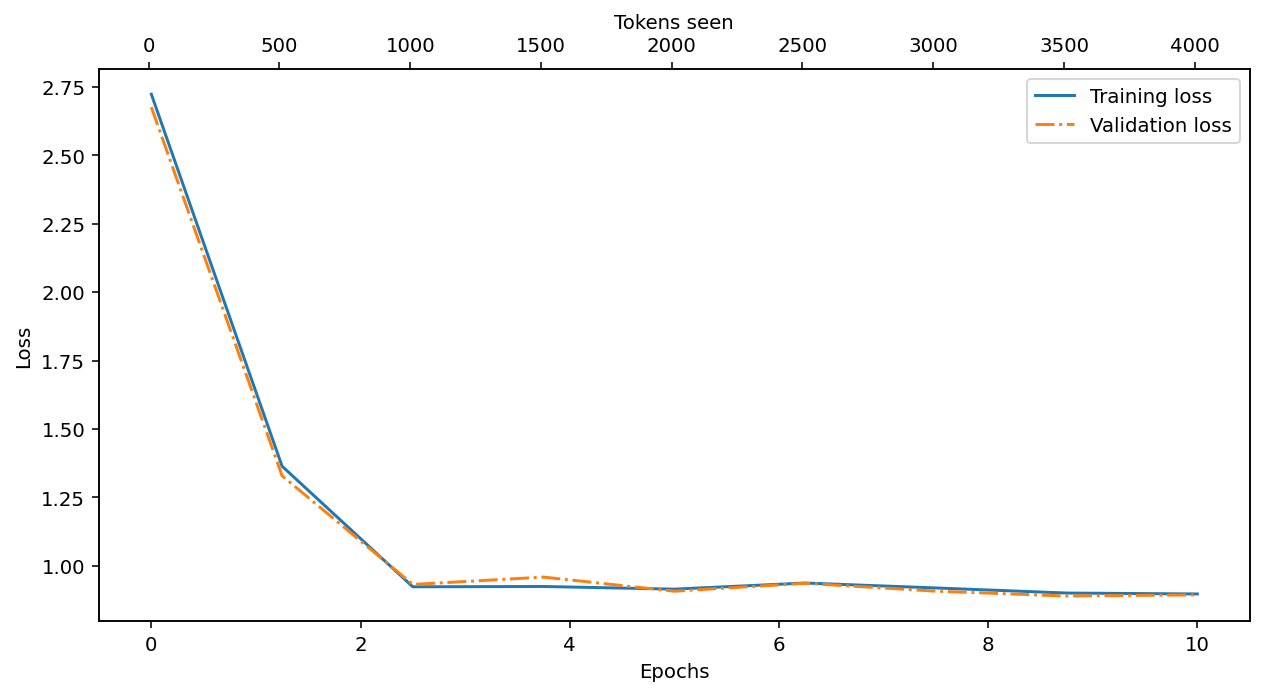

In [19]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, validation_losses)

## Checking the Embedding Changes

In [20]:
trained_embeddings = model.token_embeddings.weight.clone()

In [21]:
def classify(word: str) -> int:
    if word in adjectives:
        return 0
    if word in nouns:
        return 1
    if word in verbs:
        return 2
    return 3

classes = {
    0: "Adjective",
    1: "Noun",
    2: "Verb",
    3: "Keyword",
}

classification = {token: classify(word) for token, word in tokenizer.int_to_str.items()}
classification

{0: 3,
 1: 3,
 2: 3,
 3: 1,
 4: 0,
 5: 2,
 6: 2,
 7: 1,
 8: 1,
 9: 1,
 10: 0,
 11: 2,
 12: 0,
 13: 0,
 14: 2}

In [22]:
colors = {
    0: "tab:blue",
    1: "tab:green",
    2: "tab:red",
    3: "tab:purple",
}

In [23]:
def scat_umap_embeddings(ax: Axes, embeddings: torch.tensor, title: str):
    reducer = umap.UMAP(n_components = 2)
    reduced_embeddings = reducer.fit_transform(embeddings.tolist())
    groups = np.array(list(classification.values()))
    for group in np.unique(groups):
        index = np.where(groups == group)
        ax.scatter(
            reduced_embeddings[index][:, 0],
            reduced_embeddings[index][:, 1],
            s = 128,
            c = colors[group],
            label = classes[group]
        )
    ax.legend()
    ax.set_title(title)

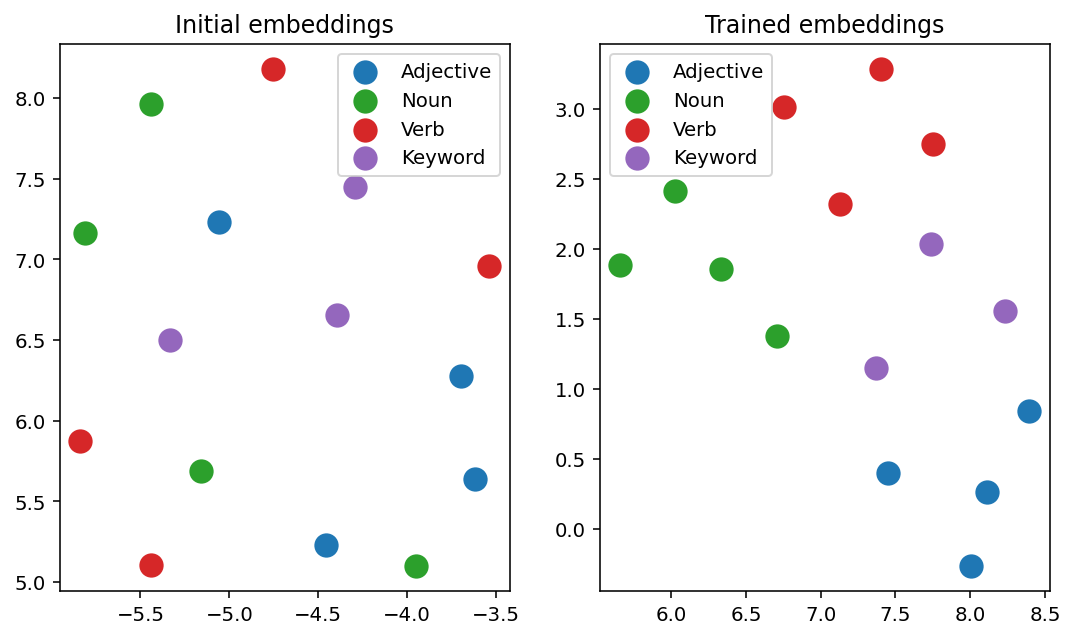

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figwidth(9)
fig.set_figheight(5)
fig.set_dpi(142)

scat_umap_embeddings(ax1, initial_embeddings, "Initial embeddings")
scat_umap_embeddings(ax2, trained_embeddings, "Trained embeddings")

plt.show()